### Задача тематическое моделирование

продолжаем исследование датасета с твитами

Скачиваем датасет ([источник](http://study.mokoron.com/)): [положительные](https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0), [отрицательные](https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv).

или можно через ноутбук

!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv

как альтернатива можно скачать данные из Роспотребнадзора 
https://zpp.rospotrebnadzor.ru/Forum/Appeals
для этого берём ноутбук `parse_rospotrebnadzor.ipynb`
устанавливаем количество скачанных страниц больше не 50-сят хотябы 500 и для анализа берём только вопросы так как ответы есть не всегда

что надо сделать 
1. объединить в одну выборку (это только для твитов), для роспотребнадзора сформировать датасет из вопросов
2. провести исследование и выявить тематики о которых говорят в твитах (для твитов), а для роспотребнадзора так же выявить тематики о которых люди пишут проанализировать
3. сделать визуализацию кластеров тематик
4. проинтерпритировать получившиеся тематики


In [20]:
import pandas as pd
import string
import pymorphy2
from nltk.corpus import stopwords
from gensim.models import Word2Vec, FastText
import numpy as np
from tqdm.notebook import tqdm
import re
from multiprocessing import Pool
from pymystem3 import Mystem

In [2]:
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
df = positive.append(negative)

C:\Users\user\AppData\Local\Temp\ipykernel_18124\1182536666.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = positive.append(negative)


In [3]:
texts = list(df['text'])

In [15]:
words_regex = re.compile('\w+')
morph = pymorphy2.MorphAnalyzer()
def find_words(text, regex = words_regex):
    tokens =  regex.findall(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) >= 3]

stopwords_list = stopwords.words('russian')

def lemmatize(words, lemmer = morph, stopwords = stopwords_list):
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if not w in stopwords 
            and w.isalpha()]

def preprocess(text):
    return (lemmatize(find_words(text)))

In [21]:
preprocessed_text = list(tqdm(map(preprocess, texts), total=len(texts)))

  0%|          | 0/226834 [00:00<?, ?it/s]

In [24]:
from gensim.models import *
from gensim import corpora

In [25]:
dictionary = corpora.Dictionary(preprocessed_text)

dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None) # игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря 
dictionary.save('tweet.dict')

In [26]:
corpus = [dictionary.doc2bow(text) for text in preprocessed_text]
corpora.MmCorpus.serialize('tweet.model', corpus) 

In [35]:
%time lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=10, chunksize=50, update_every=1, passes=10)

CPU times: total: 10min 31s
Wall time: 10min 31s


In [36]:
lda.show_topics(num_topics=10, num_words=10, formatted=True)

[(0,
  '0.084*"очень" + 0.064*"блин" + 0.044*"писать" + 0.040*"дом" + 0.033*"хотеться" + 0.026*"стать" + 0.016*"пора" + 0.016*"ненавидеть" + 0.016*"скучно" + 0.015*"работать"'),
 (1,
  '0.081*"мочь" + 0.077*"день" + 0.070*"сегодня" + 0.045*"человек" + 0.036*"большой" + 0.031*"хороший" + 0.025*"час" + 0.019*"ждать" + 0.017*"настроение" + 0.017*"плохой"'),
 (2,
  '0.071*"просто" + 0.041*"жизнь" + 0.032*"никто" + 0.032*"плохо" + 0.028*"неделя" + 0.020*"понять" + 0.018*"прийтись" + 0.018*"вроде" + 0.017*"закончиться" + 0.016*"понедельник"'),
 (3,
  '0.083*"весь" + 0.041*"свой" + 0.035*"смотреть" + 0.034*"болеть" + 0.029*"думать" + 0.023*"утро" + 0.021*"каждый" + 0.018*"пока" + 0.017*"забыть" + 0.015*"найти"'),
 (4,
  '0.085*"ещё" + 0.045*"почему" + 0.035*"сказать" + 0.028*"пойти" + 0.028*"который" + 0.027*"время" + 0.020*"ночь" + 0.019*"последний" + 0.017*"работа" + 0.016*"скоро"'),
 (5,
  '0.175*"всё" + 0.026*"говорить" + 0.018*"наш" + 0.016*"вчера" + 0.016*"нужно" + 0.016*"прийти" + 0.01

!pip install pyLDAvis

In [37]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

%time vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

C:\Users\user\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


CPU times: total: 8.25 s
Wall time: 11.6 s


In [38]:
print(lda.log_perplexity(corpus))

-9.534947923226854


In [44]:
coherence_model_lda = CoherenceModel(model=lda, texts=preprocessed_text, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

Средняя когерентность:  0.181509525534092


In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

  0%|          | 0/5 [00:00<?, ?it/s]

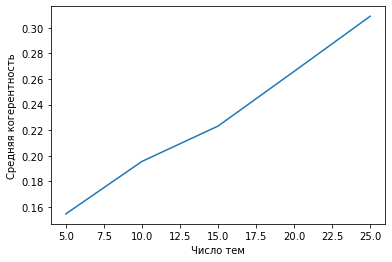

In [46]:
topics_list = [5, 10, 15, 20, 25]
coherences = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, texts=preprocessed_text, dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

In [ ]:
coherence_model_lda = CoherenceModel(model=lda_top, texts=preprocessed_text, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)